#ADE-Net


Code and Paper by: Nicholas Soucy and Dr. Salimeh Yasaei Sekeh

##Initial Setup

### Imports

In [ ]:
#imports

import torch

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# #### Importing


#imports
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import utils
from sklearn import mixture
from sklearn.neighbors import KNeighborsClassifier
import sklearn.preprocessing as sp
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
import os
import os.path as osp
import torch
import torch.utils.data as data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from torch import optim
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
import tensorflow as tf
import math
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
from tqdm import trange
import torch.utils.data as data_utils
from scipy.sparse.linalg import LinearOperator as ScipyLinearOperator
from scipy.sparse.linalg import eigsh
from warnings import warn
import shutil
import sys

from numpy import savetxt
from numpy import loadtxt

Tesla T4
Mounted at /content/drive


In [ ]:
# GLOBAL VARIABLES TO CHANGE

# Batch Number
batch = 256

# Attack Stuff
attack_types = ['FGSM', 'CW', 'PGD', 'I-FGSM', 'VANILA']
num_attacks = 5

# Number of Epochs
num_epochs = 150
o_v_epochs = 25

# Number of classes IP = 16, KSC = 13, Hou = 15
class_num = 13
cls = class_num



#Model Hyperparameters
# Default Values
al = [1.0] * num_attacks     #Ensemble Class Cross Entropy Term
la = [1.0] * num_attacks     #Discriminator CKA Term
be = 1.0                     #Discriminator Attack Cross Entropy Term

#Special parameters
# al = []
# en_mod = 1.0
# if num_attacks >= 1:
#   al.append(1.4 * en_mod) #Ensemble Class Cross Entropy Term
#   be = 1.0 #Discriminator Attack Cross Entropy Term
# if num_attacks >= 2:
#   al.append(2.3 * en_mod)
#   be = 1.0
# if num_attacks >= 3:
#   al.append(1.7 * en_mod)
#   be = 1.0
# if num_attacks >= 4:
#   al.append(1.3 * en_mod)
#   be = 1.0
# if num_attacks >= 5:
#   al.append(1.0 * en_mod)
#   be = 1.0

print("Alpha Ensemble CE Term: ", al)
print("Beta Discriminator CE Term: ", be)
print("Lambda Discrim CKA Term: ",la)

Alpha Ensemble CE Term:  [1.0, 1.0, 1.0, 1.0, 1.0]
Beta Discriminator CE Term:  1.0
Lambda Discrim CKA Term:  [1.0, 1.0, 1.0, 1.0, 1.0]


## Classification Functions

### Unet

#### Pytorch Unet Class

Actual Custom Neural Network Class

In [ ]:
class UNet(nn.Module):
    def __init__(self,in_shape,class_num,want_logits=True):
        super().__init__()
        # Define Variables
        self.input_shape = in_shape
        self.class_num = class_num
        self.want_logits = want_logits
        # Define Layers:
        # NOTE: Change kernel size to be the size of the patch
        self.Conv1 = nn.Conv2d(self.input_shape, 64,kernel_size=(1,1), stride=(1,1), padding='same', bias=False)
        self.bn1 = nn.InstanceNorm1d(64)
        self.Conv2 = nn.Conv2d(64, 128,kernel_size=(1,1), stride=(2,2), bias=False)
        self.bn2 = nn.InstanceNorm1d(128)
        self.Conv3 = nn.Conv2d(128, 256,kernel_size=(1,1), stride=(2,2), bias=False)
        self.bn3 = nn.InstanceNorm1d(256)
        self.deco1 = nn.ConvTranspose2d(256,256,kernel_size=(1,1), stride=(1,1), bias=False)
        self.deco2 = nn.ConvTranspose2d(384,128,kernel_size=(1,1), stride=(1,1), bias=False)
        self.deco3 = nn.ConvTranspose2d(192,class_num,kernel_size=(1,1), stride=(1,1))

        # Define Activation functions:
        self.drop = nn.Dropout(0.2)
        self.Lrelu = nn.LeakyReLU()
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        """
        Layers: 4
        Activation Functions:
        RELU for first two layers
        Sigmoid for third layer
        Log Softmax for last layer
        """
        # import pdb;pdb.set_trace()
        x = self.Conv1(x)
        # x = x.view(int(x.shape[0]),int(x.shape[1]/2),2)
        # x = self.bn1(x)
        # x = x.view(int(x.shape[0]),int(x.shape[1]*x.shape[2]),1,1)
        x = self.Lrelu(x)
        x = self.drop(x)
        op1 = x

        x = self.Conv2(x)
        # x = x.view(int(x.shape[0]),int(x.shape[1]/2),2)
        # x = self.bn2(x)
        # x = x.view(int(x.shape[0]),int(x.shape[1]*x.shape[2]),1,1)
        x = self.Lrelu(x)
        x = self.drop(x)
        op2 = x

        x = self.Conv3(x)
        # x = x.view(int(x.shape[0]),int(x.shape[1]/2),2)
        # x = self.bn3(x)
        # x = x.view(int(x.shape[0]),int(x.shape[1]*x.shape[2]),1,1)
        x = self.Lrelu(x)
        x = self.drop(x)
        op3 = x

        x = self.deco1(x)
        # x = x.view(int(x.shape[0]),int(x.shape[1]/2),2)
        # x = self.bn3(x)
        # x = x.view(int(x.shape[0]),int(x.shape[1]*x.shape[2]),1,1)
        x = self.Lrelu(x)
        x = self.drop(x)
        x = torch.cat((x, op2), dim=1)

        x = self.deco2(x)
        # x = x.view(int(x.shape[0]),int(x.shape[1]/2),2)
        # x = self.bn2(x)
        # x = x.view(int(x.shape[0]),int(x.shape[1]*x.shape[2]),1,1)
        x = self.Lrelu(x)
        x = self.drop(x)
        x = torch.cat((x, op1), dim=1)

        x = self.deco3(x)
        x = torch.reshape(x, (x.shape[0], self.class_num))

        if(self.want_logits):
          return x
        else:
          x = self.softmax(x)
          return x

#### Discrim+Ensemble Network

##### Loss Function

Custom Disciminator Loss Function

In [ ]:
def custom_loss_dis(discriminator,
                    output_dis,
                    x,
                    y,
                    c,
                    O_v,
                    num_attacks,
                    lam=None,
                    beta=1.0):
    # define cross entropy loss
    ce = torch.nn.CrossEntropyLoss()
    output_dis_orig = output_dis

    # Get Discriminator term 3
    term3 = (beta * ce(output_dis_orig, c))



    # Get Discriminator term 2
    if lam != None or lam[0] != 0:
        _, predicted_dis_orig = torch.max(output_dis.data, 1)
        output_dis = output_dis.cpu().detach().numpy()
        predicted_dis = predicted_dis_orig.cpu().detach().numpy()



        #Get O_k
        O_k = []
        for i in range(num_attacks):
            mask = predicted_dis_orig.eq(i).to(device)
            indexes = torch.arange(0, predicted_dis_orig.shape[0]).type(torch.LongTensor).to(device)
            masked_indexes = torch.masked_select(indexes,mask).type(torch.LongTensor).to(device)
            O_k.append(torch.index_select(output_dis_orig, 0, masked_indexes).cpu().detach().numpy())


        #Calculate term2
        term2 = [] * num_attacks
        for i in range(num_attacks):
            term2.append(lam[i]*cka(np.array(O_v).T, np.array(O_k[i]).T))
            if np.isnan(term2[-1]):
                term2[-1] = 1
        term2_sum = torch.sum(torch.tensor(term2))


        # calculate custom loss
        loss = term2_sum + term3

        return loss, term2
    else:
        return term3, 0

Model Generation

##### Model stuff

Full Train Test Function

In [ ]:
def single_train_test(train_loader, test_loader, alpha, beta, lam, num_attacks = 3, num_epochs=20, class_num=13, learning_rate=0.001):

    for i, (images, labels, a_labels) in enumerate(train_loader):
        in_shape = images.shape[1]
        break

    # Create Models and send to correct device
    discriminator = UNet(in_shape,num_attacks)  # Intialize the NN
    ensemble_models = []
    for i in range(num_attacks):
        ensemble_models.append(UNet(in_shape,class_num))
        ensemble_models[i] = ensemble_models[i].to(device)
    discriminator = discriminator.to(device)

    # Create optimizer
    optimizer_dis = optim.Adam(discriminator.parameters(), lr=learning_rate)
    optimizers_en = []
    for i in range(num_attacks):
        optimizers_en.append(optim.Adam(ensemble_models[i].parameters(), lr=learning_rate))

	#Create scheduelers
    scheduler_dis = optim.lr_scheduler.CosineAnnealingLR(optimizer_dis, T_max=200)
    schedulers_en = []
    for i in range(num_attacks):
        schedulers_en.append(optim.lr_scheduler.CosineAnnealingLR(optimizers_en[i], T_max=200))

    ce = torch.nn.CrossEntropyLoss()


    # Set parameters for training
    if alpha == None:
        alpha = [1.0] * num_attacks

    if lam == None:
        lam = [1.0] * num_attacks

    train_running_loss = [] * num_epochs
    train_dis_loss = [] * num_epochs
    train_en_loss = [] * num_epochs

    dis_running_acc = [] * num_epochs
    en_running_acc = [] * num_epochs

    ckas = []

    # Set parameters for testing
    test_dis_running_acc = [] * num_epochs
    test_en_running_acc = [] * num_epochs




    for epoch in range(num_epochs):

        #Training Stuff
        temp_loss = 0
        temp_dis_loss = 0
        temp_en_loss = 0

        correct_dis = 0
        total_dis = 0
        correct_en = 0
        total_en = 0

        ckas.append([])

        #Testing Stuff
        correct_test_en = 0
        total_test_en = 0
        correct_test_dis = 0
        total_test_dis = 0




        ## training step

        # Set networks to train
        discriminator.train()
        for i in range(num_attacks):
            ensemble_models[i].train()

        for idx, (images, labels, a_labels) in enumerate(train_loader):

            # print("On batch: ",idx)

            images = images.clone().detach().requires_grad_(True)
            labels = labels.clone().detach().requires_grad_(True)
            a_labels = a_labels.clone().detach().requires_grad_(True)

            labels = labels.type(torch.LongTensor)  # casting to long
            a_labels = a_labels.type(torch.LongTensor)  # casting to long

            images = images.to(device)
            labels = labels.to(device)
            a_labels = a_labels.to(device)

            ckas[epoch].append([])


            # Calculate gradient and update weights of discriminator network
            optimizer_dis.zero_grad()
            output_dis = discriminator(images)
            loss_dis, curr_ckas = custom_loss_dis(discriminator,
                                       output_dis,
                                       images,
                                       labels,
                                       a_labels,
                                       O_v,
                                       num_attacks,
                                       lam=lam,
                                       beta=beta)
            #print("Curr CKAs: ",curr_ckas)
            loss_dis.backward()
            optimizer_dis.step()
            temp_dis_loss += loss_dis.detach().item()
            total_dis += a_labels.size(0)
            _, predicted_dis = torch.max(output_dis.data, 1)
            correct_dis += (predicted_dis == a_labels).sum().item()

            ckas[epoch][idx].append(curr_ckas)


             


            # Calculate gradient and update weights of ensemble network
            temp_en_loss_step = 0
            for i in range(num_attacks):
                optimizers_en[i].zero_grad()


                mask = predicted_dis.eq(i).to(device)
                indexes = torch.arange(0, predicted_dis.shape[0]).type(torch.LongTensor).to(device)
                masked_indexes = torch.masked_select(indexes,mask).type(torch.LongTensor).to(device)
                temp_images = torch.index_select(images, 0, masked_indexes)
                temp_labels = torch.index_select(labels, 0, masked_indexes)

                
                total_en += temp_labels.size(0)
                if temp_labels.shape[0] >= 1:
                    output_en = ensemble_models[i](temp_images)
                    loss_en = (alpha[i] * ce(output_en, temp_labels))
                    loss_en.backward()
                    optimizers_en[i].step()
                    temp_en_loss_step += loss_en
                    _, predicted_en = torch.max(output_en.data, 1)
                    correct_en += (predicted_en == temp_labels).sum().item()
            temp_en_loss += temp_en_loss_step.detach().item()


             



            # Add both losses together for total loss function
            temp_loss += temp_dis_loss + temp_en_loss





        ## Testing step

        #Set each network to eval
        discriminator.eval()
        for i in range(num_attacks):
            ensemble_models[i].eval()

        for idx, (images, labels, a_labels) in enumerate(test_loader):

            #Get data
            images = images.clone().detach().requires_grad_(True)
            labels = labels.clone().detach().requires_grad_(True)
            a_labels = a_labels.clone().detach().requires_grad_(True)

            #Send data to device
            images = images.to(device)
            labels = labels.to(device)
            a_labels = a_labels.to(device)

            #discriminator output
            output_dis = discriminator(images)
            _, predicted_dis = torch.max(output_dis.data, 1)
            total_test_dis += a_labels.size(0)
            correct_test_dis += (predicted_dis == a_labels).sum().item()




            for i in range(num_attacks):

                mask = predicted_dis.eq(i).to(device)
                indexes = torch.arange(0, predicted_dis.shape[0]).type(torch.LongTensor).to(device)
                masked_indexes = torch.masked_select(indexes,mask).type(torch.LongTensor).to(device)
                temp_images = torch.index_select(images, 0, masked_indexes)
                temp_labels = torch.index_select(labels, 0, masked_indexes)

                total_test_en += temp_labels.size(0)
                if temp_labels.shape[0] >= 1:
                    output_en = ensemble_models[i](temp_images)
                    _, predicted_test_en = torch.max(output_en.data, 1)
                    correct_test_en += (predicted_test_en == temp_labels).sum().item()





        train_dis_loss.append(temp_dis_loss / idx)
        train_en_loss.append(temp_en_loss / idx)
        train_running_loss.append(train_dis_loss[-1] + train_en_loss[-1])

        if total_dis == 0:
            dis_running_acc.append(0)
        else: 
            dis_running_acc.append((100 * correct_dis / total_dis))

        if total_en == 0:
            en_running_acc.append(0)
        else:
            en_running_acc.append((100 * correct_en / total_en))

        if total_test_dis == 0:
            test_dis_running_acc.append(0)
        else:        
            test_dis_running_acc.append(100 * (correct_test_dis/total_test_dis))
        
        if total_test_en == 0 :
            test_en_running_acc.append(0)
        else:
            test_en_running_acc.append(100 * (correct_test_en/total_test_en))


		#Step Schedulers
        scheduler_dis.step()
        for i in range(num_attacks):
            schedulers_en[i].step()

        
        print('Epoch: %d | Discrim Loss: %.4f | Ensemble Loss: %.4f | Total Loss: %.4f | Discrim Acc: %.4f | Ensemble Acc: %.4f | Testing Discrim Acc: %.4f | Testing Ensemble Acc: %.4f' \
              % (epoch, train_dis_loss[epoch], train_en_loss[epoch], train_running_loss[epoch], dis_running_acc[epoch], en_running_acc[epoch],test_dis_running_acc[epoch],test_en_running_acc[epoch]))

    return discriminator, ensemble_models, train_running_loss, dis_running_acc, en_running_acc, train_dis_loss, train_en_loss, ckas, test_dis_running_acc, test_en_running_acc


## CKA Functions

All equations come from: https://github.com/yuanli2333

Paper: https://arxiv.org/abs/1905.00414

In [ ]:
# ## CKA Functions

def centering(K):
    n = K.shape[0]
    unit = np.ones([n, n])
    I = np.eye(n)
    H = I - unit / n

    return np.dot(np.dot(H, K), H)  # HKH are the same with KH, KH is the first centering, H(KH) do the second time, results are the sme with one time centering
    # return np.dot(H, K)  # KH


def rbf(X, sigma=None):
    GX = np.dot(X, X.T)
    KX = np.diag(GX) - GX + (np.diag(GX) - GX).T
    if sigma is None:
        mdist = np.median(KX[KX != 0])
        sigma = math.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = np.exp(KX)
    return KX


def kernel_HSIC(X, Y, sigma):
    return np.sum((rbf(X, sigma)) * (rbf(Y, sigma)))


def linear_HSIC(X, Y):
    L_X = np.dot(X, X.T)
    L_Y = np.dot(Y, Y.T)
    return np.sum((L_X) * (L_Y))


def cka(X, Y):
    hsic = linear_HSIC(X, Y)
    var1 = np.sqrt(linear_HSIC(X, X))
    var2 = np.sqrt(linear_HSIC(Y, Y))

    return hsic / (var1 * var2)


def cka_rbf(X, Y, sigma=None):
    hsic = kernel_HSIC(X, Y, sigma)
    var1 = np.sqrt(kernel_HSIC(X, X, sigma))
    var2 = np.sqrt(kernel_HSIC(Y, Y, sigma))

    return hsic / (var1 * var2)


## Training

### Loading Data

In [ ]:
# Load vanilia and attacked datasets 

# vanilia
vanilia_train_data = np.load('{}VANILLA/x_train.npy'.format(PATH))
vanilia_train_labels = np.load('{}VANILLA/y_train.npy'.format(PATH))
vanilia_test_data = np.load('{}VANILLA/x_test.npy'.format(PATH))
vanilia_test_labels = np.load('{}VANILLA/y_test.npy'.format(PATH))

"My name is {}, I'm {}".format("John",36)

print("Vanilia Data Shape")
print(vanilia_train_data.shape)
print(vanilia_train_labels.shape)
print(vanilia_test_data.shape)
print(vanilia_test_labels.shape)
print("\n")

# fgsm
fgsm_train_data = np.load('{}FGSM/x_adv_train.npy'.format(PATH))
fgsm_train_labels = np.load('{}FGSM/y_train.npy'.format(PATH))
fgsm_test_data = np.load('{}FGSM/x_adv_test.npy'.format(PATH))
fgsm_test_labels = np.load('{}FGSM/y_test.npy'.format(PATH))

print("FGSM Data Shape")
print(fgsm_train_data.shape)
print(fgsm_train_labels.shape)
print(fgsm_test_data.shape)
print(fgsm_test_labels.shape)
print("\n")


#C_W

cw_train_data = np.load('{}CW/x_adv_train.npy'.format(PATH))
cw_train_labels = np.load('{}CW/y_train.npy'.format(PATH))
cw_test_data = np.load('{}CW/x_adv_test.npy'.format(PATH))
cw_test_labels = np.load('{}CW/y_test.npy'.format(PATH))

print("CW Data Shape")
print(cw_train_data.shape)
print(cw_train_labels.shape)
print(cw_test_data.shape)
print(cw_test_labels.shape)
print("\n")

#pgd

pgd_train_data = np.load('{}PGD/x_adv_train.npy'.format(PATH))
pgd_train_labels = np.load('{}PGD/y_train.npy'.format(PATH))
pgd_test_data = np.load('{}PGD/x_adv_test.npy'.format(PATH))
pgd_test_labels = np.load('{}PGD/y_test.npy'.format(PATH))

print("PGD Data Shape")
print(pgd_train_data.shape)
print(pgd_train_labels.shape)
print(pgd_test_data.shape)
print(pgd_test_labels.shape)
print("\n")


#ifgsm

ifgsm_train_data = np.load('{}I-FGSM/x_adv_train.npy'.format(PATH))
ifgsm_train_labels = np.load('{}I-FGSM/y_train.npy'.format(PATH))
ifgsm_test_data = np.load('{}I-FGSM/x_adv_test.npy'.format(PATH))
ifgsm_test_labels = np.load('{}I-FGSM/y_test.npy'.format(PATH))

print("I-FGSM Data Shape")
print(ifgsm_train_data.shape)
print(ifgsm_train_labels.shape)
print(ifgsm_test_data.shape)
print(ifgsm_test_labels.shape)
print("\n")

# Get attack labels


y_discrim_train = [] * num_attacks
y_discrim_test = [] * num_attacks
for i in range(num_attacks):
    temp = []
    temp_2 = []
    for j in range(np.shape(vanilia_train_data)[0]):
        temp.append(i)
    y_discrim_train.append(temp)
    for j in range(np.shape(vanilia_test_data)[0]):
        temp_2.append(i)
    y_discrim_test.append(temp_2)


a_train = np.array(y_discrim_train)
a_test = np.array(y_discrim_test)



names = []

# Create master arrays
x_train = [None] * num_attacks
x_test = [None] * num_attacks
y_train = [None] * num_attacks
y_test = [None] * num_attacks

# Merge data and labels
if num_attacks > 0:
	x_train[0] = fgsm_train_data
	y_train[0] = fgsm_train_labels
	x_test[0] = fgsm_test_data
	y_test[0] = fgsm_test_labels
if num_attacks > 1:
	x_train[1] = cw_train_data
	y_train[1] = cw_train_labels
	x_test[1] = cw_test_data
	y_test[1] = cw_test_labels
if num_attacks > 2:
	x_train[2] = pgd_train_data
	y_train[2] = pgd_train_labels
	x_test[2] = pgd_test_data
	y_test[2] = pgd_test_labels
if num_attacks > 3:
	x_train[3] = ifgsm_train_data
	y_train[3] = ifgsm_train_labels
	x_test[3] = ifgsm_test_data
	y_test[3] = ifgsm_test_labels
if num_attacks > 4:
	x_train[4] = vanilia_train_data
	y_train[4] = vanilia_train_labels
	x_test[4] = vanilia_test_data
	y_test[4] = vanilia_test_labels


# Get names and print
print("Attacks Used This Run")
for i in range(num_attacks):
    names.append(attack_types[i])
    print(names[i])
print("\n")


# Show attacked data shape


print("Combined Data Shape")
print(np.shape(x_train))
print(np.shape(x_test))
print("Combined Class Label Shape")
print(np.shape(y_train))
print(np.shape(y_test))
print("Combined Attack Label Shape")
print(np.shape(a_train))
print(np.shape(a_test))
print("\n")



Vanilia Data Shape
(3917, 30, 1, 1)
(3917,)
(1306, 30, 1, 1)
(1306,)


FGSM Data Shape
(3917, 30, 1, 1)
(3917,)
(1306, 30, 1, 1)
(1306,)


CW Data Shape
(3917, 30, 1, 1)
(3917,)
(1306, 30, 1, 1)
(1306,)


PGD Data Shape
(3917, 30, 1, 1)
(3917,)
(1306, 30, 1, 1)
(1306,)


I-FGSM Data Shape
(3917, 30, 1, 1)
(3917,)
(1306, 30, 1, 1)
(1306,)


Attacks Used This Run
FGSM
CW
PGD
I-FGSM
VANILA


Combined Data Shape
(5, 3917, 30, 1, 1)
(5, 1306, 30, 1, 1)
Combined Class Label Shape
(5, 3917)
(5, 1306)
Combined Attack Label Shape
(5, 3917)
(5, 1306)




### Getting O_V

In [ ]:
# ### Getting O_v

# In[23]:


def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def unison_shuffled_copies3(a, b, c):
    assert len(a) == len(b)
    assert len(a) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]



O_v = []

# get full data and shuffle
if num_attacks == 2:
	gt = np.concatenate((np.array(a_train[0]), np.array(a_train[1])))
	data = np.concatenate((np.array(x_train[0]), np.array(x_train[1])))
elif num_attacks == 3:
	gt = np.concatenate((np.array(a_train[0]), np.array(a_train[1]), np.array(a_train[2])))
	data = np.concatenate((np.array(x_train[0]), np.array(x_train[1]), np.array(x_train[2])))
elif num_attacks == 4:
	gt = np.concatenate((np.array(a_train[0]), np.array(a_train[1]), np.array(a_train[2]), np.array(a_train[3])))
	data = np.concatenate((np.array(x_train[0]), np.array(x_train[1]), np.array(x_train[2]), np.array(x_train[3])))
elif num_attacks == 5:
	gt = np.concatenate((np.array(a_train[0]), np.array(a_train[1]), np.array(a_train[2]), np.array(a_train[3]), np.array(a_train[4])))
	data = np.concatenate((np.array(x_train[0]), np.array(x_train[1]), np.array(x_train[2]), np.array(x_train[3]), np.array(x_train[4])))



data, gt = unison_shuffled_copies(data, gt)

# convert to Tensors
gt = torch.Tensor(gt)  # Use attack labels because this is for the discriminator
data = torch.Tensor(data)


# create datasets
dataset = data_utils.TensorDataset(data, gt)
train_loader = data_utils.DataLoader(dataset, batch_size=batch, shuffle=False, pin_memory=True)

# train discriminator
for i, (images, labels) in enumerate(train_loader):
    in_shape = images.shape[1]
    break
discriminator = UNet(in_shape,num_attacks)
discriminator.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train_temp(epoch):
    print('\nEpoch: %d' % epoch)
    discriminator.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        targets = targets.type(torch.LongTensor)
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = discriminator(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss / (batch_idx + 1), 100. * correct / total, correct, total))


for epoch in trange(o_v_epochs):
    # for epoch in trange(1):
    train_temp(epoch)
    scheduler.step()

print("Getting Activations")
for l in trange(np.shape(vanilia_train_data)[0]):
    temp_input = torch.from_numpy(np.expand_dims(vanilia_train_data[l], 0))
    temp_input = temp_input.type(torch.FloatTensor)
    temp_input = temp_input.to(device)
    temp_activation = discriminator(temp_input)
    temp_activation = torch.squeeze(temp_activation)
    O_v.append(temp_activation.cpu().detach().numpy())

print("\nDone O_v Training, O_v shape = ",np.shape(O_v))



  0%|          | 0/25 [00:00<?, ?it/s]


Epoch: 0


  4%|▍         | 1/25 [00:03<01:24,  3.52s/it]

Loss: 1.236 | Acc: 49.083% (9613/19585)

Epoch: 1


  8%|▊         | 2/25 [00:04<00:43,  1.90s/it]

Loss: 0.738 | Acc: 66.066% (12939/19585)

Epoch: 2


 12%|█▏        | 3/25 [00:04<00:29,  1.32s/it]

Loss: 0.580 | Acc: 71.825% (14067/19585)

Epoch: 3


 16%|█▌        | 4/25 [00:05<00:22,  1.07s/it]

Loss: 0.513 | Acc: 73.342% (14364/19585)

Epoch: 4


 20%|██        | 5/25 [00:06<00:19,  1.03it/s]

Loss: 0.481 | Acc: 74.164% (14525/19585)

Epoch: 5


 24%|██▍       | 6/25 [00:06<00:14,  1.31it/s]

Loss: 0.465 | Acc: 74.067% (14506/19585)

Epoch: 6


 28%|██▊       | 7/25 [00:07<00:11,  1.58it/s]

Loss: 0.450 | Acc: 74.940% (14677/19585)

Epoch: 7


 32%|███▏      | 8/25 [00:07<00:09,  1.85it/s]

Loss: 0.452 | Acc: 75.078% (14704/19585)

Epoch: 8


 36%|███▌      | 9/25 [00:07<00:07,  2.06it/s]

Loss: 0.436 | Acc: 75.292% (14746/19585)

Epoch: 9


 40%|████      | 10/25 [00:08<00:06,  2.25it/s]

Loss: 0.424 | Acc: 75.747% (14835/19585)

Epoch: 10


 44%|████▍     | 11/25 [00:08<00:05,  2.40it/s]

Loss: 0.420 | Acc: 75.716% (14829/19585)

Epoch: 11


 48%|████▊     | 12/25 [00:08<00:05,  2.53it/s]

Loss: 0.413 | Acc: 75.982% (14881/19585)

Epoch: 12


 52%|█████▏    | 13/25 [00:09<00:04,  2.60it/s]

Loss: 0.413 | Acc: 76.084% (14901/19585)

Epoch: 13


 56%|█████▌    | 14/25 [00:09<00:04,  2.67it/s]

Loss: 0.405 | Acc: 76.191% (14922/19585)

Epoch: 14


 60%|██████    | 15/25 [00:09<00:03,  2.71it/s]

Loss: 0.404 | Acc: 76.002% (14885/19585)

Epoch: 15


 64%|██████▍   | 16/25 [00:10<00:03,  2.71it/s]

Loss: 0.400 | Acc: 76.303% (14944/19585)

Epoch: 16


 68%|██████▊   | 17/25 [00:10<00:02,  2.69it/s]

Loss: 0.397 | Acc: 76.426% (14968/19585)

Epoch: 17


 72%|███████▏  | 18/25 [00:11<00:02,  2.76it/s]

Loss: 0.392 | Acc: 76.354% (14954/19585)

Epoch: 18


 76%|███████▌  | 19/25 [00:11<00:02,  2.80it/s]

Loss: 0.390 | Acc: 76.676% (15017/19585)

Epoch: 19


 80%|████████  | 20/25 [00:11<00:01,  2.80it/s]

Loss: 0.387 | Acc: 76.696% (15021/19585)

Epoch: 20


 84%|████████▍ | 21/25 [00:12<00:01,  2.83it/s]

Loss: 0.384 | Acc: 76.890% (15059/19585)

Epoch: 21


 88%|████████▊ | 22/25 [00:12<00:01,  2.83it/s]

Loss: 0.381 | Acc: 76.727% (15027/19585)

Epoch: 22


 92%|█████████▏| 23/25 [00:12<00:00,  2.83it/s]

Loss: 0.380 | Acc: 76.936% (15068/19585)

Epoch: 23


 96%|█████████▌| 24/25 [00:13<00:00,  2.86it/s]

Loss: 0.376 | Acc: 77.028% (15086/19585)

Epoch: 24


100%|██████████| 25/25 [00:13<00:00,  1.85it/s]


Loss: 0.375 | Acc: 77.258% (15131/19585)
Getting Activations


100%|██████████| 3917/3917 [00:03<00:00, 1062.43it/s]


Done O_v Training, O_v shape =  (3917, 5)


Get Full dataset

In [ ]:
# get full data and shuffle
if num_attacks == 2:
	gt_a = np.concatenate((np.array(a_train[0]), np.array(a_train[1])))
	data = np.concatenate((np.array(x_train[0]), np.array(x_train[1])))
	gt = np.concatenate((np.array(y_train[0]), np.array(y_train[1])))

	gt_a_t = np.concatenate((np.array(a_test[0]), np.array(a_test[1])))
	data_t = np.concatenate((np.array(x_test[0]), np.array(x_test[1])))
	gt_t = np.concatenate((np.array(y_test[0]), np.array(y_test[1])))
elif num_attacks == 3:
	gt_a = np.concatenate((np.array(a_train[0]), np.array(a_train[1]), np.array(a_train[2])))
	data = np.concatenate((np.array(x_train[0]), np.array(x_train[1]), np.array(x_train[2])))
	gt = np.concatenate((np.array(y_train[0]), np.array(y_train[1]), np.array(y_train[2])))

	gt_a_t = np.concatenate((np.array(a_test[0]), np.array(a_test[1]), np.array(a_test[2])))
	data_t = np.concatenate((np.array(x_test[0]), np.array(x_test[1]), np.array(x_test[2])))
	gt_t = np.concatenate((np.array(y_test[0]), np.array(y_test[1]), np.array(y_test[2])))
elif num_attacks == 4:
	gt_a = np.concatenate((np.array(a_train[0]), np.array(a_train[1]), np.array(a_train[2]), np.array(a_train[3])))
	data = np.concatenate((np.array(x_train[0]), np.array(x_train[1]), np.array(x_train[2]), np.array(x_train[3])))
	gt = np.concatenate((np.array(y_train[0]), np.array(y_train[1]), np.array(y_train[2]), np.array(y_train[3])))

	gt_a_t = np.concatenate((np.array(a_test[0]), np.array(a_test[1]), np.array(a_test[2]), np.array(a_test[3])))
	data_t = np.concatenate((np.array(x_test[0]), np.array(x_test[1]), np.array(x_test[2]), np.array(x_test[3])))
	gt_t = np.concatenate((np.array(y_test[0]), np.array(y_test[1]), np.array(y_test[2]), np.array(y_test[3])))
elif num_attacks == 5:
	gt_a = np.concatenate((np.array(a_train[0]), np.array(a_train[1]), np.array(a_train[2]), np.array(a_train[3]), np.array(a_train[4])))
	data = np.concatenate((np.array(x_train[0]), np.array(x_train[1]), np.array(x_train[2]), np.array(x_train[3]), np.array(x_train[4])))
	gt = np.concatenate((np.array(y_train[0]), np.array(y_train[1]), np.array(y_train[2]), np.array(y_train[3]), np.array(y_train[4])))

	gt_a_t = np.concatenate((np.array(a_test[0]), np.array(a_test[1]), np.array(a_test[2]), np.array(a_test[3]), np.array(a_test[4])))
	data_t = np.concatenate((np.array(x_test[0]), np.array(x_test[1]), np.array(x_test[2]), np.array(x_test[3]), np.array(x_test[4])))
	gt_t = np.concatenate((np.array(y_test[0]), np.array(y_test[1]), np.array(y_test[2]), np.array(y_test[3]), np.array(y_test[4])))


data, gt, gt_a = unison_shuffled_copies3(data, gt, gt_a)
data_t, gt_t, gt_a_t = unison_shuffled_copies3(data_t, gt_t, gt_a_t)

#print shapes
print("Mixed Dataset Shapes")
print("Mixed Train Data Shape: ", np.shape(data))
print("Mixed Train Class Labels Shape: ", np.shape(gt))
print("Mixed Train Attack Labels Shape: ", np.shape(gt_a))

print("Mixed Test Data Shape: ", np.shape(data_t))
print("Mixed Test Class Labels Shape: ", np.shape(gt_t))
print("Mixed Test Attack Labels Shape: ", np.shape(gt_a_t))
print("\n")


# convert to Tensors
gt = torch.Tensor(gt)
data = torch.Tensor(data)
gt_a = torch.Tensor(gt_a)

gt_t = torch.Tensor(gt_t)
data_t = torch.Tensor(data_t)
gt_a_t = torch.Tensor(gt_a_t)


# create datasets
dataset = data_utils.TensorDataset(data, gt, gt_a)
dataset_t = data_utils.TensorDataset(data_t, gt_t, gt_a_t)
train_loader = data_utils.DataLoader(dataset, batch_size=batch, shuffle=False, pin_memory=True)
test_loader = data_utils.DataLoader(dataset_t, batch_size=batch, shuffle=False, pin_memory=True)



Mixed Dataset Shapes
Mixed Train Data Shape:  (19585, 30, 1, 1)
Mixed Train Class Labels Shape:  (19585,)
Mixed Train Attack Labels Shape:  (19585,)
Mixed Test Data Shape:  (6530, 30, 1, 1)
Mixed Test Class Labels Shape:  (6530,)
Mixed Test Attack Labels Shape:  (6530,)




### Full Training

In [ ]:
discriminator, ensemble_models, loss_list, acc_dis, acc_en, dis_loss_list, en_loss_list, ckas, test_dis_running_acc, test_en_running_acc = single_train_test(train_loader, test_loader, al, be, la, num_attacks = num_attacks, num_epochs=num_epochs, class_num=class_num)


<ipython-input-6-61487f61db75>:39: RuntimeWarning: invalid value encountered in float_scalars
  return hsic / (var1 * var2)


Epoch: 0 | Discrim Loss: 8.7666 | Ensemble Loss: 29.6714 | Total Loss: 38.4380 | Discrim Acc: 43.5997 | Ensemble Acc: 33.9903 | Testing Discrim Acc: 60.8882 | Testing Ensemble Acc: 53.9969
Epoch: 1 | Discrim Loss: 11.0319 | Ensemble Loss: 19.3329 | Total Loss: 30.3648 | Discrim Acc: 65.5502 | Ensemble Acc: 56.2471 | Testing Discrim Acc: 72.3124 | Testing Ensemble Acc: 65.6968
Epoch: 2 | Discrim Loss: 10.5249 | Ensemble Loss: 15.7012 | Total Loss: 26.2261 | Discrim Acc: 70.6510 | Ensemble Acc: 64.8660 | Testing Discrim Acc: 74.0735 | Testing Ensemble Acc: 69.7703
Epoch: 3 | Discrim Loss: 10.3717 | Ensemble Loss: 13.8149 | Total Loss: 24.1866 | Discrim Acc: 72.2645 | Ensemble Acc: 68.5014 | Testing Discrim Acc: 74.9923 | Testing Ensemble Acc: 74.0888
Epoch: 4 | Discrim Loss: 9.9985 | Ensemble Loss: 12.7248 | Total Loss: 22.7233 | Discrim Acc: 73.6022 | Ensemble Acc: 71.3607 | Testing Discrim Acc: 75.4824 | Testing Ensemble Acc: 75.5436
Epoch: 5 | Discrim Loss: 10.0828 | Ensemble Loss: 11

## CKA Figure generation

In [24]:
ckas_np = np.asarray(ckas)
ckas_np = ckas_np.reshape(ckas_np.shape[0],ckas_np.shape[-1],ckas_np.shape[1])
avg_ckas = []
for i in range(num_epochs):
  avg_ckas.append(np.average(ckas_np[i], axis=1))
avg_ckas = np.asarray(avg_ckas)
avg_ckas = avg_ckas.reshape(avg_ckas.shape[-1],avg_ckas.shape[0])
print("Average CKA Shape: ",avg_ckas.shape)

Average CKA Shape:  (5, 150)


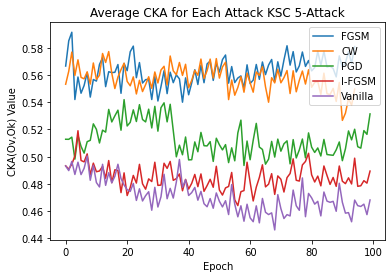

In [23]:
plt.plot(avg_ckas[0][15:110], label="FGSM")
plt.plot(avg_ckas[1][15:110], label="CW")
plt.plot(avg_ckas[2][10:110], label="PGD")
plt.plot(avg_ckas[3][10:110], label="I-FGSM")
plt.plot(avg_ckas[4][10:110], label="Vanilla")
plt.xlabel("Epoch")
plt.ylabel("CKA(Ov,Ok) Value")
plt.title('Average CKA for Each Attack {} {}-Attack'.format(dataset,num_attacks))
plt.legend(loc="upper right")
plt.locator_params(axis="x", integer=True, tight=True)
# plt.savefig("cka.pdf",dpi=500)
plt.show()

In [ ]:
# np.save('avg_ckas',avg_ckas)

## Reporting

In [ ]:
print("Discriminator Training Accuracy: ",max(acc_dis))
print("Ensemble Training Accuracy: ",max(acc_en))

Discriminator Training Accuracy:  79.11156497319377
Ensemble Training Accuracy:  88.93540975236151


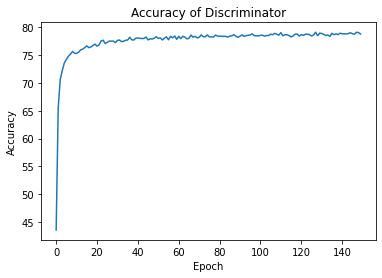

In [ ]:
plt.plot(acc_dis)
plt.title('Accuracy of Discriminator')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

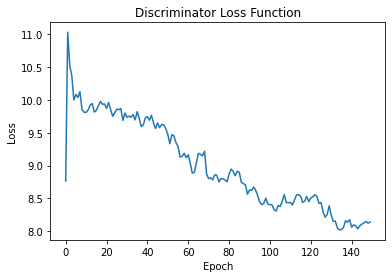

In [ ]:
plt.plot(dis_loss_list)
plt.title('Discriminator Loss Function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

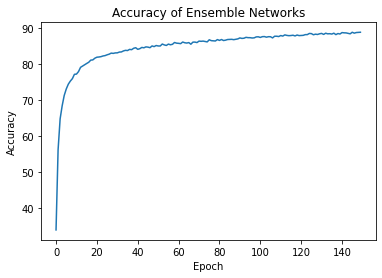

In [ ]:
plt.plot(acc_en)
plt.title('Accuracy of Ensemble Networks')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

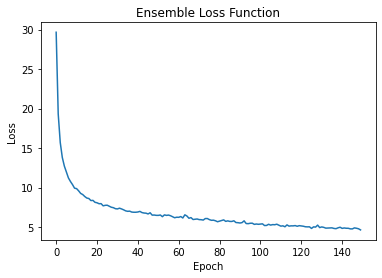

In [ ]:
plt.plot(en_loss_list)
plt.title('Ensemble Loss Function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

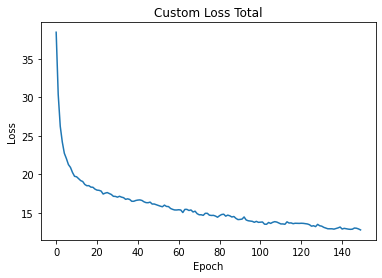

In [ ]:
plt.plot(loss_list)
plt.title('Custom Loss Total')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Testing

In [ ]:
print("Discriminator Testing Accuracy: ", max(test_dis_running_acc))
print("Ensemble Testing Accuracy: ",max(test_en_running_acc))

Discriminator Testing Accuracy:  78.69831546707505
Ensemble Testing Accuracy:  88.65237366003062


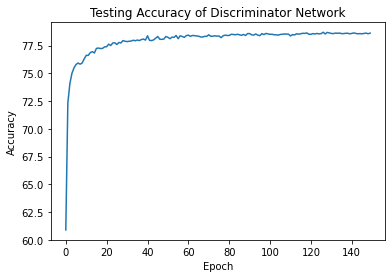

In [ ]:
plt.plot(test_dis_running_acc)
plt.title('Testing Accuracy of Discriminator Network')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

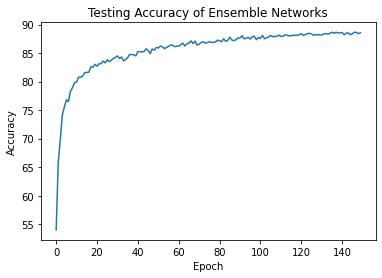

In [ ]:
plt.plot(test_en_running_acc)
plt.title('Testing Accuracy of Ensemble Networks')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()